Сочетания Сn по k 

1. пример с присяжными

2. пример с весом быка на рынке (большое кол-во наблюдений, в результате средний вес оказался точным)

In [1]:
import math

In [2]:
math.factorial(5)

120

In [6]:
0.6*0.6

0.36

bootstrap sampling - разделение данных на семплы , при этом они могут пересекаться. 

то есть достаем наблюдение, а потом возвращаем его обратно в корзину

### Беггинг - 
это ансамбль независимых алгоритмов (моделей), которые подобраны по набутстрапленым выборкам

считается средний скор всех вердиктов

алгоритм major vote - голосованием принимаем решение, к какому классу отнести 

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\mosco\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
np.random.seed(42)

In [4]:
n_train = 150
n_test = 1000
noise = 0.1

In [6]:
def f(x):    
    x = x.ravel()
    return np.exp(-x**2)+1.5*np.exp(-(x-2)**2)

def generate(n_samples, noise):
    # random.rand возвращает число от 0 до 1
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y 

In [9]:
X_train , y_train = generate(n_samples = n_train, noise = noise)
X_test , y_test = generate(n_samples = n_test, noise = noise)

In [12]:
dtree = DecisionTreeRegressor()

dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)


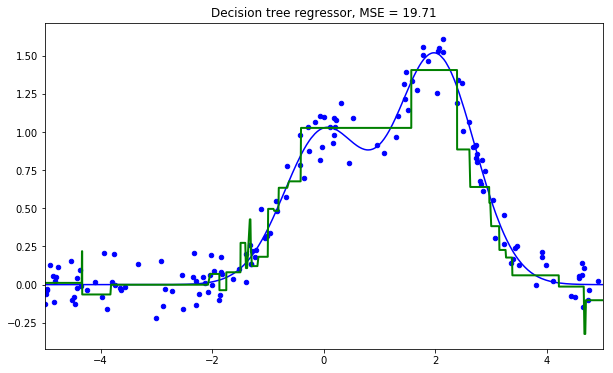

In [16]:

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c='b', s=20)
plt.plot(X_test, reg_tree_pred, 'g', lw=2)
plt.xlim([-5, 5])
#plt.title('Decision tree regressor, MSE = %.2f' % np.sum((y_test - reg_tree_pred)**2))

plt.title('Decision tree regressor, MSE = {0}'.format(round(np.sum((y_test - reg_tree_pred)**2), 2)))

plt.show()

### Выбор алгоритма

Обычно всегда тестируют несколько алгоритмов (из ансамблей) и потом выбрают лучший по метрике по тестовой или валидационной выборке 

Если отличается сильно метрика (раза в полтора) то надо разбираться 


In [17]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), n_samples)
    samples = data[indices]
    return samples


In [21]:
np.random.randint(0, 3, 2)

array([1, 1])

In [24]:
dtrees_bagging = []
def bagging_fit(X, y, n_trees=10):
    full_X_y = np.array(list(zip(np.array(X)[:, 0], y)))
    for t in range(n_trees):
        samp_X_y = get_bootstrap_samples(
        full_X_y,
        int(len(full_X_y)/1.5))
        
        X_new = samp_X_y[:, 0].reshape((len(samp_X_y), 1))
        y_new = samp_X_y[:, 1]
        dtrees_bagging.append(DecisionTreeRegressor().fit(X_new, y_new))

In [38]:
data = np.array([[1,2],[3,4],[5,6]])

In [39]:
len(data)

3

In [40]:
get_bootstrap_samples(data=data, n_samples=3)

array([[5, 6],
       [1, 2],
       [3, 4]])

In [41]:
def bagging_predict(X):
    # возвращаем конкретное число по каждому наблюдению
    # бежим по кажлому дереву и добавляем предикт в список
    d_predicts = []
    for dtree in dtrees_bagging:
        d_predicts.append(dtree.predict(X))
    d_predicts = np.array(d_predicts)
    return np.mean(d_predicts, axis=0)

In [51]:
bagging_fit(X_train, y_train, n_trees=100)

In [52]:
bgt_predict = bagging_predict(X_test)

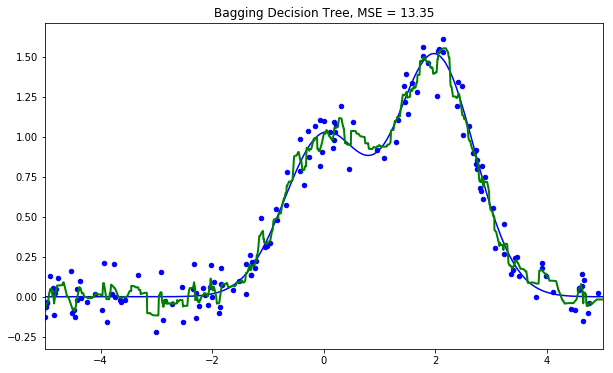

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c='b', s=20)
plt.plot(X_test, bgt_predict, 'g', lw=2)
plt.xlim([-5, 5])
#plt.title('Decision tree regressor, MSE = %.2f' % np.sum((y_test - reg_tree_pred)**2))

plt.title('Bagging Decision Tree, MSE = {0}'.format(round(np.sum((y_test - bgt_predict)**2), 2)))

plt.show()

В результате ошибка на ансамбле уменьшилась, причем довольно сильно!

In [54]:
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

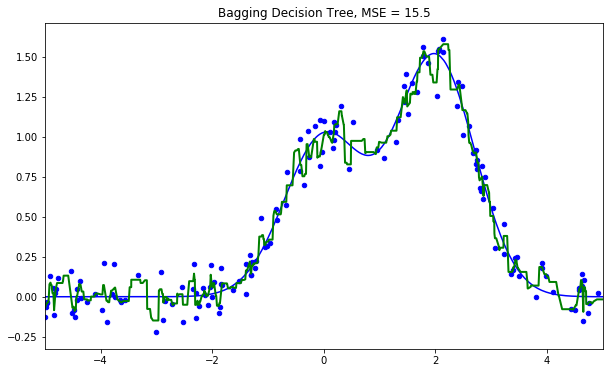

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c='b', s=20)
plt.plot(X_test, bdt_predict, 'g', lw=2)
plt.xlim([-5, 5])
#plt.title('Decision tree regressor, MSE = %.2f' % np.sum((y_test - reg_tree_pred)**2))

plt.title('Bagging Decision Tree, MSE = {0}'.format(round(np.sum((y_test - bdt_predict)**2), 2)))

plt.show()

## Лес (RandomForest)

- это еще одна модификация беггинга

по сути это тот же беггинг над деревьями, с одним ключевым отличием - есть дополнительный семплинг по факторам

там используется  не только бутстрап выборки (наблюдений), но и бутстреп факторов


он считается наиболее крутым беггинггом, показывает хорошую устойчивость к переобучениям. 
То есть если мы на каком-то факторе переобучаемся, то Лес позволяет этого избежать , так как часть деревьев его не учитывает.

Его стоит пробовать в одну из первых очередей в продакшн решениях

Но он иногда недообучается


Самый крутой алгоритм - градиентный бустинг

In [58]:
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

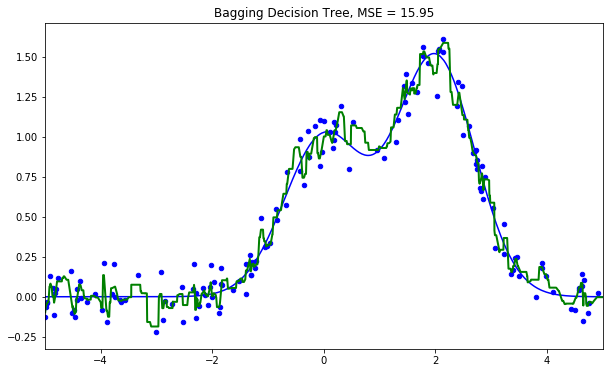

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c='b', s=20)
plt.plot(X_test, rf_predict, 'g', lw=2)
plt.xlim([-5, 5])
#plt.title('Decision tree regressor, MSE = %.2f' % np.sum((y_test - reg_tree_pred)**2))

plt.title('Bagging Decision Tree, MSE = {0}'.format(round(np.sum((y_test - rf_predict)**2), 2)))

plt.show()